In [16]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth', -1)
from matplotlib import pyplot as plt
import seaborn as sns
import keras
from keras.layers import Dense, Embedding, LSTM, Dropout
from keras.models import Sequential
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
import sqlite3
from tqdm import tqdm
import re
from bs4 import BeautifulSoup

from sklearn.model_selection import train_test_split

In [7]:

# using the SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 
#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 50000""", con) 
#filtered_data = pd.read_sql_query("""SHOW TABLES""", con) 
# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (50000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [8]:
review_data=filtered_data[['Text','Score']].reset_index(drop=True)
review_data

,Text,Score
0,I have bought several of the Vitality canned d...,1
1,Product arrived labeled as Jumbo Salted Peanut...,0
2,This is a confection that has been around a fe...,1
3,If you are looking for the secret ingredient i...,0
4,Great taffy at a great price. There was a wid...,1
...,...,...
49995,i had taste tested this when a friend gave a c...,1
49996,I bought this coffee in the hopes that it woul...,0
49997,I'm going to go broke drinking these. I disco...,1
49998,"Reviews for coffee can be hard, because everyo...",1


In [11]:
## Data preprocessing
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

sorted_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
22620,24750,2734888454,A13ISQV0U9GZIC,Sandikaye,1,1,0,1192060800,made in china,My dogs loves this chicken but its a product f...
22621,24751,2734888454,A1C298ITT645B6,Hugh G. Pritchard,0,0,1,1195948800,Dog Lover Delites,Our dogs just love them. I saw them in a pet ...
2546,2774,B00002NCJC,A196AJHU9EASJN,Alex Chaffee,0,0,1,1282953600,thirty bucks?,Why is this $[...] when the same product is av...
2547,2775,B00002NCJC,A13RRPGE79XFFH,reader48,0,0,1,1281052800,Flies Begone,We have used the Victor fly bait for 3 seasons...
1145,1244,B00002Z754,A3B8RCEI0FXFI6,B G Chase,10,10,1,962236800,WOW Make your own 'slickers' !,I just received my shipment and could hardly w...


In [12]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape



(46072, 10)

In [14]:

#Removing the anamolies
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

final.shape

(46071, 10)

In [17]:


#Preprocessing
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase


preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    # sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())
    
## Similartly you can do preprocessing for review summary also.
def concatenateSummaryWithText(str1, str2):
    return str1 + ' ' + str2

preprocessed_summary = []
# tqdm is for printing the status bar
for sentence in tqdm(final['Summary'].values):
    sentence = re.sub(r"http\S+", "", sentence)
    #sentence = BeautifulSoup(sentence, 'lxml').get_text()
    sentence = decontracted(sentence)
    sentence = re.sub("\S*\d\S*", "", sentence).strip()
    sentence = re.sub('[^A-Za-z]+', ' ', sentence)
    # https://gist.github.com/sebleier/554280
    # sentence = ' '.join(e.lower() for e in sentence.split() if e.lower() not in stopwords)
    preprocessed_summary.append(sentence.strip())
    


100%|██████████| 46071/46071 [00:00<00:00, 78561.54it/s]


In [18]:
preprocessed_reviews = list(map(concatenateSummaryWithText, preprocessed_reviews, preprocessed_summary))
final['CleanedText'] = preprocessed_reviews
final['CleanedText'] = final['CleanedText'].astype('str')

In [19]:
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
22620,24750,2734888454,A13ISQV0U9GZIC,Sandikaye,1,1,0,1192060800,made in china,"My dogs loves this chicken but its a product from China, so we wont be buying it anymore. Its very hard to find any chicken products made in the USA but they are out there, but this one isnt. Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.",My dogs loves this chicken but its a product from China so we wont be buying it anymore Its very hard to find any chicken products made in the USA but they are out there but this one isnt Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports made in china
22621,24751,2734888454,A1C298ITT645B6,Hugh G. Pritchard,0,0,1,1195948800,Dog Lover Delites,Our dogs just love them. I saw them in a pet store and a tag was attached regarding them being made in China and it satisfied me that they were safe.,Our dogs just love them I saw them in a pet store and a tag was attached regarding them being made in China and it satisfied me that they were safe Dog Lover Delites
2546,2774,B00002NCJC,A196AJHU9EASJN,Alex Chaffee,0,0,1,1282953600,thirty bucks?,"Why is this $[...] when the same product is available for $[...] here?<br />http://www.amazon.com/VICTOR-FLY-MAGNET-BAIT-REFILL/dp/B00004RBDY<br /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.",Why is this when the same product is available for here The Victor and traps are unreal of course total fly genocide Pretty stinky but only right nearby thirty bucks
2547,2775,B00002NCJC,A13RRPGE79XFFH,reader48,0,0,1,1281052800,Flies Begone,We have used the Victor fly bait for 3 seasons. Can't beat it. Great product!,We have used the Victor fly bait for seasons Ca not beat it Great product Flies Begone
1145,1244,B00002Z754,A3B8RCEI0FXFI6,B G Chase,10,10,1,962236800,WOW Make your own 'slickers' !,"I just received my shipment and could hardly wait to try this product. We love &quot;slickers&quot; which is what we call them, instead of stickers because they can be removed so easily. My daughter designed signs to be printed in reverse to use on her car windows. They printed beautifully (we have 'The Print Shop' program). I am going to have a lot of fun with this product because there are windows everywhere and other surfaces like tv screens and computer monitors.",I just received my shipment and could hardly wait to try this product We love slickers which is what we call them instead of stickers because they can be removed so easily My daughter designed signs to be printed in reverse to use on her car windows They printed beautifully we have The Print Shop program I am going to have a lot of fun with this product because there are windows everywhere and other surfaces like tv screens and computer monitors WOW Make your own islickers


In [20]:
preprocessed_reviews[1500]

'Great flavor low in calories high in nutrients high in protein Usually protein powders are high priced and high in calories this one is a great bargain and tastes great I highly recommend for the lady gym rats probably not macho enough for guys since it is soy based gym rat bargain'

Segregating the input and output data from the dataset.

We will be using the Cleaned Text i.e preprocessed data from the dataset and score for that text

In [21]:
X = final['CleanedText']
y = final['Score']

In [22]:
del final
del preprocessed_reviews
del preprocessed_summary
del sorted_data
del filtered_data

In [23]:
X_t, X_test, y_t, y_test = train_test_split(X, y, test_size=0.20, stratify=y, shuffle=True)
X_train, X_cv, y_train, y_cv = train_test_split(X_t, y_t, test_size=0.20, stratify=y_t, shuffle=True)
print("Shape of Input  - Train:", X_train.shape)
print("Shape of Output - Train:", y_train.shape)
print("Shape of Input  - CV   :", X_cv.shape)
print("Shape of Output - CV   :", y_cv.shape)
print("Shape of Input  - Test :", X_test.shape)
print("Shape of Output - Test :", y_test.shape)

Shape of Input  - Train: (29484,)
Shape of Output - Train: (29484,)
Shape of Input  - CV   : (7372,)
Shape of Output - CV   : (7372,)
Shape of Input  - Test : (9215,)
Shape of Output - Test : (9215,)


Tokenizing the dataset

In [24]:
tokenize = Tokenizer(num_words=5000)
tokenize.fit_on_texts(X_train)

X_train_new = tokenize.texts_to_sequences(X_train)
X_cv_new = tokenize.texts_to_sequences(X_cv)
X_test_new = tokenize.texts_to_sequences(X_test)

print(X_train_new[1])
print(len(X_train_new))

[2, 1192, 9, 525, 81, 5, 52, 60, 196, 15, 18, 2087, 36, 122, 19, 901, 2, 50, 433, 2, 93, 81, 2, 38, 599, 1, 220, 23, 1, 2447, 67, 589, 387, 4088, 122, 81, 21, 954, 711, 213, 3, 3517, 63, 74, 6, 1292, 2, 44, 62, 74, 667, 81, 1, 591, 3174, 23, 29, 82, 284, 8, 1488, 2, 109, 10, 4448, 1, 131, 711, 213, 474, 12, 110, 25, 21, 37, 12, 13, 74, 6, 494, 3, 13, 74, 38, 4780, 28, 131, 2, 290, 27, 81, 21, 199, 108, 36, 284, 8, 196, 15, 44, 30, 185, 11, 107, 384, 2, 187, 9, 163, 412, 48, 69, 17, 50, 433, 7, 238, 2, 34, 81, 188, 31, 203, 7, 90, 131, 9, 151, 32, 239, 292, 13, 124, 74, 525, 3, 13, 1967, 6, 68]
29484


#### Padding the dataset
- This is just to give batch input to the RNN

In [25]:
# truncate and/or pad input sequences
max_review_length = 1000
X_train_new = sequence.pad_sequences(X_train_new, maxlen=max_review_length)
X_cv_new = sequence.pad_sequences(X_cv_new, maxlen=max_review_length)
X_test_new = sequence.pad_sequences(X_test_new, maxlen=max_review_length)

print(X_train_new.shape)
print(X_train_new[1])

(29484, 1000)
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0   

In [26]:
# https://gist.github.com/greydanus/f6eee59eaf1d90fcb3b534a25362cea4
# https://stackoverflow.com/a/14434334
# this function is used to update the plots for each epoch and error
def plt_dynamic(x, vy, ty, ax, colors=['b']):
    ax.plot(x, vy, 'b', label="Validation Loss")
    ax.plot(x, ty, 'r', label="Train Loss")
    plt.legend()
    plt.grid()
    fig.canvas.draw()
    
n_epochs = 5
batchsize = 512

final_output = pd.DataFrame(columns=["Model", "Architecture",
                                     "TRAIN_LOSS", "TEST_LOSS", "TRAIN_ACC", "TEST_ACC"]);

Model M1 ( Embedding -> LSTM -> Output(Sigmoid) )¶

In [27]:
# create the model
embed_vector_length = 32
model = Sequential()
model.add(Embedding(5000, embed_vector_length, input_length=max_review_length))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print("***********************************************")
print("Printing the Model Summary")
print(model.summary())
print("***********************************************")

***********************************************
Printing the Model Summary
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1000, 32)          160000    
_________________________________________________________________
lstm (LSTM)                  (None, 100)               53200     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 213,301
Trainable params: 213,301
Non-trainable params: 0
_________________________________________________________________
None
***********************************************


Epoch 1/5
58/58 [==============================] - 209s 4s/step - loss: 0.0913 - accuracy: 0.9684 - val_loss: 0.1809 - val_accuracy: 0.9345
Epoch 2/5
58/58 [==============================] - 213s 4s/step - loss: 0.0843 - accuracy: 0.9703 - val_loss: 0.1897 - val_accuracy: 0.9289
Epoch 3/5
58/58 [==============================] - 207s 4s/step - loss: 0.0756 - accuracy: 0.9743 - val_loss: 0.1922 - val_accuracy: 0.9292
Epoch 4/5
58/58 [==============================] - 208s 4s/step - loss: 0.0689 - accuracy: 0.9768 - val_loss: 0.2108 - val_accuracy: 0.9295
Epoch 5/5
18/18 [==============================] - 17s 921ms/step - loss: 0.2050 - accuracy: 0.9312
Test score: 0.20502980053424835
Test accuracy: 0.9311991333961487


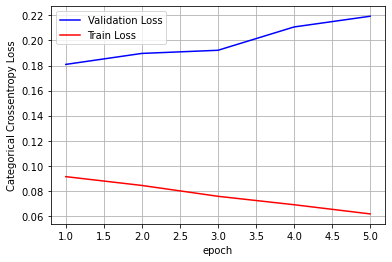

In [29]:
m_hist = model.fit(X_train_new, y_train, epochs=n_epochs, 
                   batch_size=batchsize, verbose=1, validation_data=(X_cv_new, y_cv))

score = model.evaluate(X_test_new, y_test, batch_size=batchsize)
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

final_output = final_output.append({"Model": 1,
                                    "Architecture": 'Embedding-LSTM-Sigmoid', 
                                    "TRAIN_LOSS": '{:.5f}'.format(m_hist.history["loss"][n_epochs-1]),
                                    "TEST_LOSS": '{:.5f}'.format(score[0]),
                                    "TRAIN_ACC": '{:.5f}'.format(m_hist.history["accuracy"][n_epochs-1]),
                                    "TEST_ACC": '{:.5f}'.format(score[1])}, ignore_index=True)

fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch')
ax.set_ylabel('Categorical Crossentropy Loss')

# list of epoch numbers
x = list(range(1,n_epochs+1))

vy = m_hist.history['val_loss']
ty = m_hist.history['loss']
plt_dynamic(x, vy, ty, ax)

Model M2 ( Embedding -> LSTM -> Dropout -> Dense(128-Relu) -> Dropout -> Dense (64-Relu) -> Dropout -> Output(Sigmoid) 

In [30]:
# create the model
embed_vector_length = 32
model = Sequential()
model.add(Embedding(5000, embed_vector_length, input_length=max_review_length))
model.add(LSTM(100))
model.add(Dropout(rate=0.5))
model.add(Dense(128, activation='relu', kernel_initializer='he_normal'))
model.add(Dropout(rate=0.5))
model.add(Dense(64, activation='relu', kernel_initializer='he_normal'))
model.add(Dropout(rate=0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print("***********************************************")
print("Printing the Model Summary")
print(model.summary())
print("***********************************************")

***********************************************
Printing the Model Summary
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1000, 32)          160000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               12928     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_____________________________________________

18/18 [==============================] - 13s 698ms/step - loss: 0.6926 - accuracy: 0.6214
Test score: 0.6925972700119019
Test accuracy: 0.6213781833648682


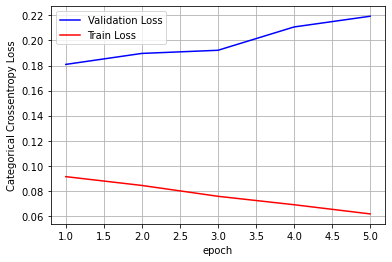

In [31]:
score = model.evaluate(X_test_new, y_test, batch_size=batchsize)
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

final_output = final_output.append({"Model": 2,
                                    "Architecture": 'Embedding-LSTM-Dropout-Dense(128-Relu)-Dropout-Dense(64-Relu)-Dropout-Sigmoid', 
                                    "TRAIN_LOSS": '{:.5f}'.format(m_hist.history["loss"][n_epochs-1]),
                                    "TEST_LOSS": '{:.5f}'.format(score[0]),
                                    "TRAIN_ACC": '{:.5f}'.format(m_hist.history["accuracy"][n_epochs-1]),
                                    "TEST_ACC": '{:.5f}'.format(score[1])}, ignore_index=True)

fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch')
ax.set_ylabel('Categorical Crossentropy Loss')

# list of epoch numbers
x = list(range(1,n_epochs+1))

vy = m_hist.history['val_loss']
ty = m_hist.history['loss']
plt_dynamic(x, vy, ty, ax)

Model M3 ( Embedding -> LSTM -> LSTM -> Output(Sigmoid) )

In [32]:
# create the model
embed_vector_length = 32
model = Sequential()
model.add(Embedding(5000, embed_vector_length, input_length=max_review_length))
model.add(LSTM(100, return_sequences=True))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print("***********************************************")
print("Printing the Model Summary")
print(model.summary())
print("***********************************************")

***********************************************
Printing the Model Summary
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 1000, 32)          160000    
_________________________________________________________________
lstm_2 (LSTM)                (None, 1000, 100)         53200     
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 101       
Total params: 293,701
Trainable params: 293,701
Non-trainable params: 0
_________________________________________________________________
None
***********************************************


Epoch 1/5
58/58 [==============================] - 351s 6s/step - loss: 0.4241 - accuracy: 0.8402 - val_loss: 0.2549 - val_accuracy: 0.8973
Epoch 2/5
58/58 [==============================] - 448s 8s/step - loss: 0.1840 - accuracy: 0.9264 - val_loss: 0.1857 - val_accuracy: 0.9265
Epoch 3/5
58/58 [==============================] - 829s 14s/step - loss: 0.1313 - accuracy: 0.9504 - val_loss: 0.1719 - val_accuracy: 0.9357
Epoch 4/5
58/58 [==============================] - 851s 15s/step - loss: 0.1073 - accuracy: 0.9607 - val_loss: 0.1782 - val_accuracy: 0.9274
Epoch 5/5
18/18 [==============================] - 41s 2s/step - loss: 0.1782 - accuracy: 0.9327
Test score: 0.1781543493270874
Test accuracy: 0.9327183961868286


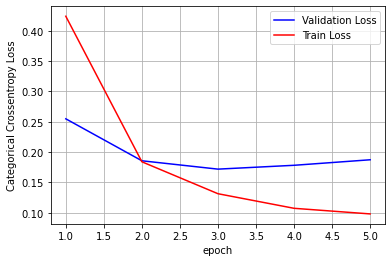

In [33]:
m_hist = model.fit(X_train_new, y_train, epochs=n_epochs, 
                   batch_size=batchsize, verbose=1, validation_data=(X_cv_new, y_cv))

score = model.evaluate(X_test_new, y_test, batch_size=batchsize)
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

final_output = final_output.append({"Model": 3,
                                    "Architecture": 'Embedding-LSTM-LSTM-Sigmoid', 
                                    "TRAIN_LOSS": '{:.5f}'.format(m_hist.history["loss"][n_epochs-1]),
                                    "TEST_LOSS": '{:.5f}'.format(score[0]),
                                    "TRAIN_ACC": '{:.5f}'.format(m_hist.history["accuracy"][n_epochs-1]),
                                    "TEST_ACC": '{:.5f}'.format(score[1])}, ignore_index=True)

fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch')
ax.set_ylabel('Categorical Crossentropy Loss')

# list of epoch numbers
x = list(range(1,n_epochs+1))

vy = m_hist.history['val_loss']
ty = m_hist.history['loss']
plt_dynamic(x, vy, ty, ax)

In [34]:
final_output

,Model,Architecture,TRAIN_LOSS,TEST_LOSS,TRAIN_ACC,TEST_ACC
0,1,Embedding-LSTM-Sigmoid,0.06156,0.20503,0.98050,0.93120
1,2,Embedding-LSTM-Dropout-Dense(128-Relu)-Dropout-Dense(64-Relu)-Dropout-Sigmoid,0.06156,0.69260,0.98050,0.62138
2,3,Embedding-LSTM-LSTM-Sigmoid,0.09801,0.17815,0.96493,0.93272


Here,

The dataset which we used is Amazon fine food reviews dataset. There are a couple different models that we tried -

Model 1 was having architecture with one LSTM layer.
Model 2 was having architecture with one LSTM layer, intermediate dropouts set to 0.5 and 2 dense hidden layers with ReLU activation
Model 3 was having architecture with 2 LSTM layers.
Conclusion that can be drawn from the above models is that All the models are performing great in terms of execution. All of them are converging very faster.

Though Model 3 with 2 LSTM layers converges a little bit faster but it is requiring more training time.